In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

In [2]:
import logging
import os

import matplotlib
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

sns.set(style='white', context='talk')

# Make analysis reproducible
np.random.seed(0)

# Enable logging
logging.basicConfig(level=logging.INFO)

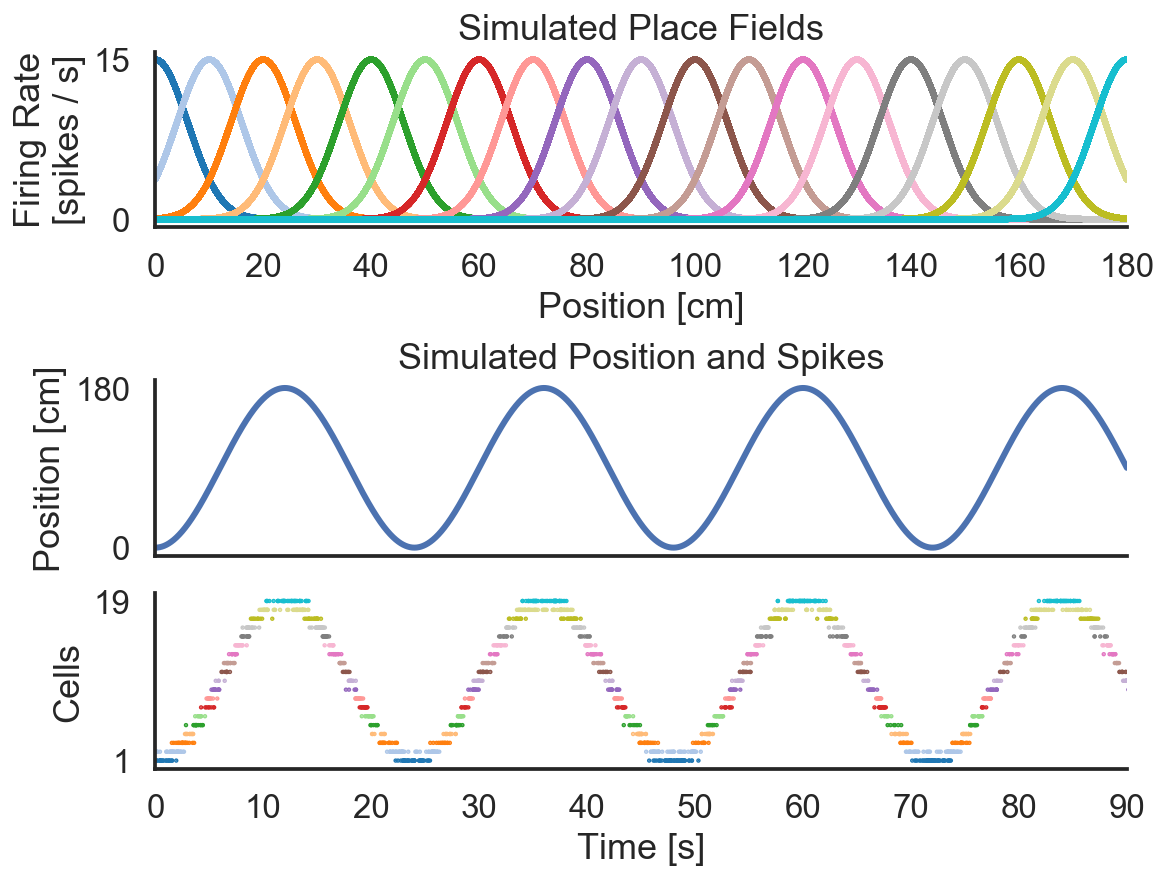

In [3]:
from src.sorted_spikes_simulation import make_simulated_run_data
from src.figure_utilities import TWO_COLUMN, GOLDEN_RATIO

time, linear_distance, sampling_frequency, spikes, place_fields = make_simulated_run_data()
spike_ind, neuron_ind = np.nonzero(spikes)
cmap = plt.get_cmap('tab20')

fig, axes = plt.subplots(3, 1, figsize=(8, 6), constrained_layout=True)
for place_field, color in zip(place_fields.T, cmap.colors):
    axes[0].plot(linear_distance, place_field, linewidth=3, color=color)
axes[0].set_xlabel('Position [cm]')
axes[0].set_ylabel('Firing Rate\n[spikes / s]')
axes[0].set_title('Simulated Place Fields')
axes[0].set_xlim((linear_distance.min(), linear_distance.max()))
axes[0].set_yticks([0, np.round(place_fields.max())])

axes[1].plot(time, linear_distance, linewidth=3)
axes[1].set_ylabel('Position [cm]')
axes[1].set_title('Simulated Position and Spikes')
axes[1].set_yticks([0, np.round(linear_distance.max())])
axes[1].set_xticks([])
axes[1].set_xlim((0.0, 90.0))

c = [cmap.colors[ind] for ind in neuron_ind]
axes[2].scatter(time[spike_ind], neuron_ind + 1, c=c, s=0.5)
axes[2].set_yticks((1, spikes.shape[1]))
axes[2].set_ylabel('Cells')

axes[2].set_xlabel('Time [s]')
axes[2].set_xlim((0.0, 90.0))

sns.despine()

In [4]:
from replay_trajectory_classification import SortedSpikesClassifier, SortedSpikesDecoder
from replay_trajectory_classification.state_transition import estimate_movement_var

movement_var = estimate_movement_var(linear_distance, sampling_frequency)

decoder = SortedSpikesDecoder(movement_var=movement_var,
                                    replay_speed=120,
                                    spike_model_penalty=0.5,
                                    place_bin_size=np.sqrt(movement_var))
decoder.fit(linear_distance, spikes)

INFO:replay_trajectory_classification.decoder:Fitting initial conditions...
INFO:replay_trajectory_classification.decoder:Fitting state transition...
INFO:replay_trajectory_classification.decoder:Fitting place fields...


SortedSpikesDecoder(infer_track_interior=True,
                    initial_conditions_type='uniform_on_track', knot_spacing=10,
                    movement_var=0.2775841643294233,
                    place_bin_size=0.526862566832588, position_range=None,
                    replay_speed=120, spike_model_penalty=0.5,
                    transition_type='random_walk')

In [237]:
from src.sorted_spikes_simulation import make_continuous_replay

replay_time, test_spikes = make_continuous_replay()

results = decoder.predict(test_spikes, time=replay_time)

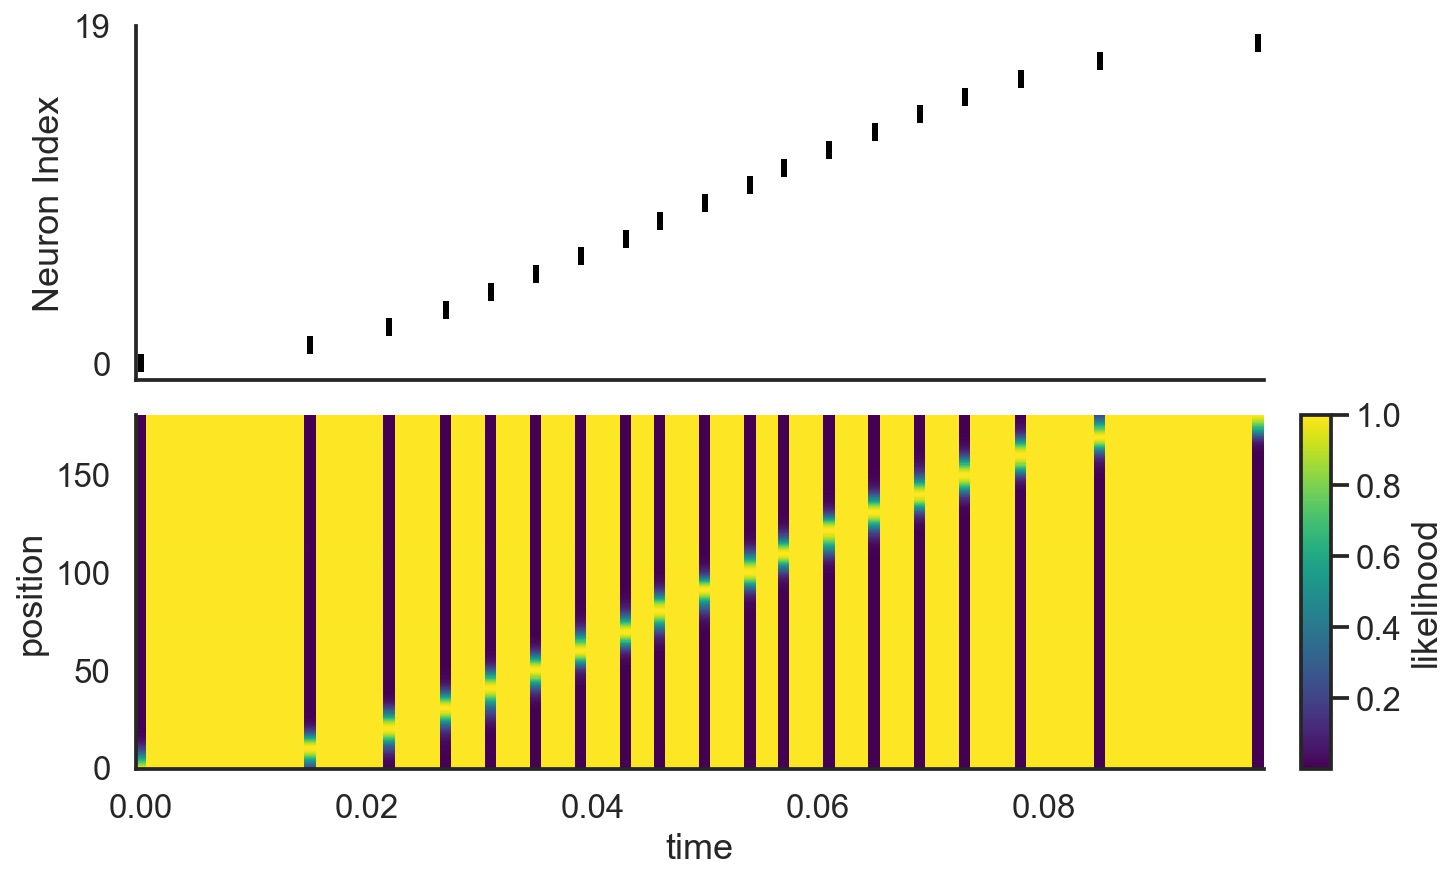

In [242]:
fig, axes = plt.subplots(2, 1, figsize=(10, 6), constrained_layout=True, sharex=True)
spike_time_ind, neuron_ind = np.nonzero(test_spikes)
axes[0].scatter(replay_time[spike_time_ind], neuron_ind, color='black', zorder=1,
                marker='|', s=80, linewidth=3)
axes[0].set_yticks((0, test_spikes.shape[1]))
axes[0].set_ylabel('Neuron Index')
results.likelihood.plot(x='time', y='position', ax=axes[1])

sns.despine()

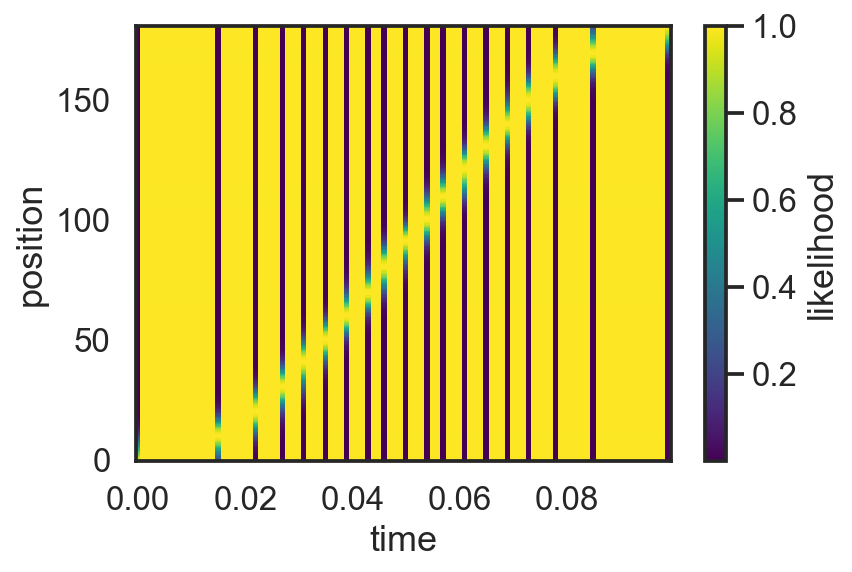

In [230]:
results.likelihood.plot(x='time', y='position')

In [6]:
results

<xarray.Dataset>
Dimensions:            (position: 344, time: 100)
Coordinates:
  * time               (time) float64 0.0 0.001 0.002 ... 0.097 0.098 0.099
  * position           (position) float64 -0.2632 0.2632 0.7895 ... 179.7 180.3
Data variables:
    likelihood         (time, position) float64 1.0 0.9551 0.9119 ... 0.9789 1.0
    causal_posterior   (time, position) float64 0.0 0.07707 ... 0.06462 0.06614
    acausal_posterior  (time, position) float64 0.0 0.05675 ... 0.06462 0.06614
    acausal_prior      (time, position) float64 0.0 0.04932 0.04817 ... 0.0 0.0

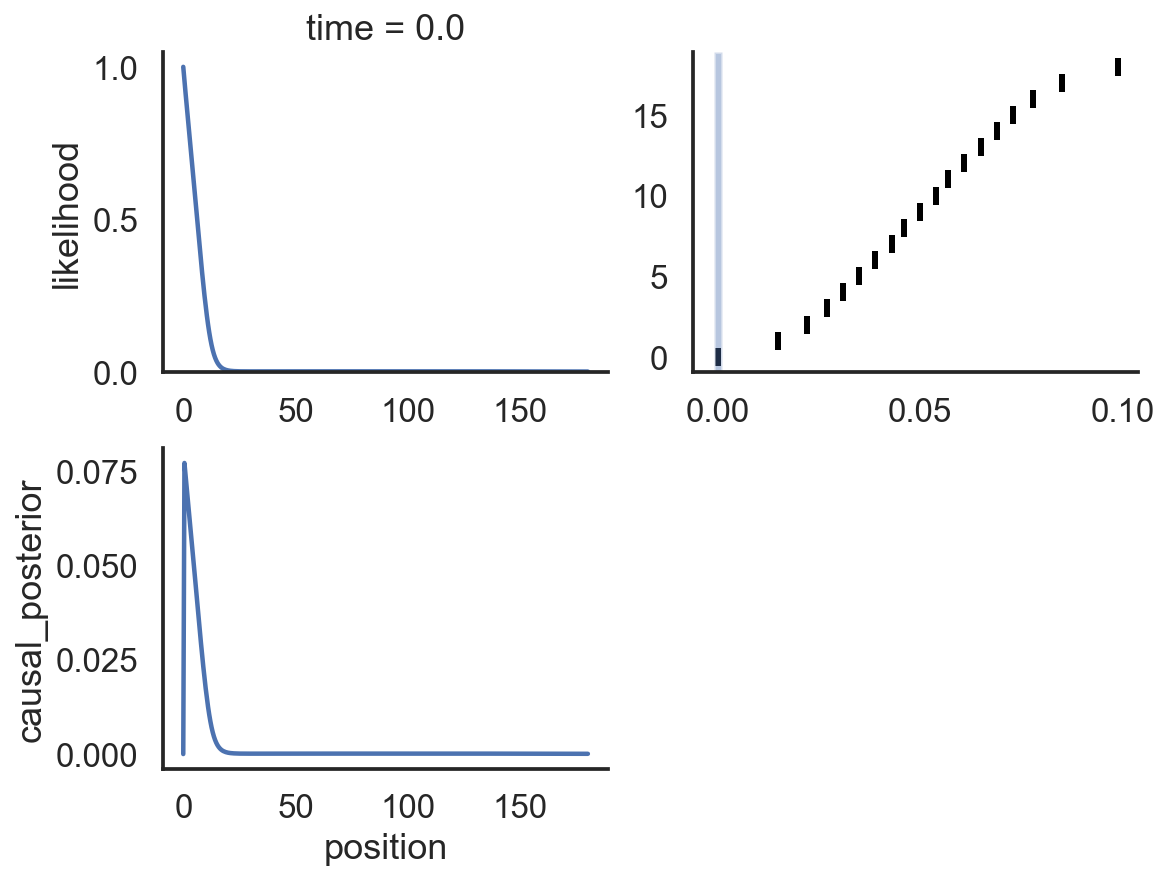

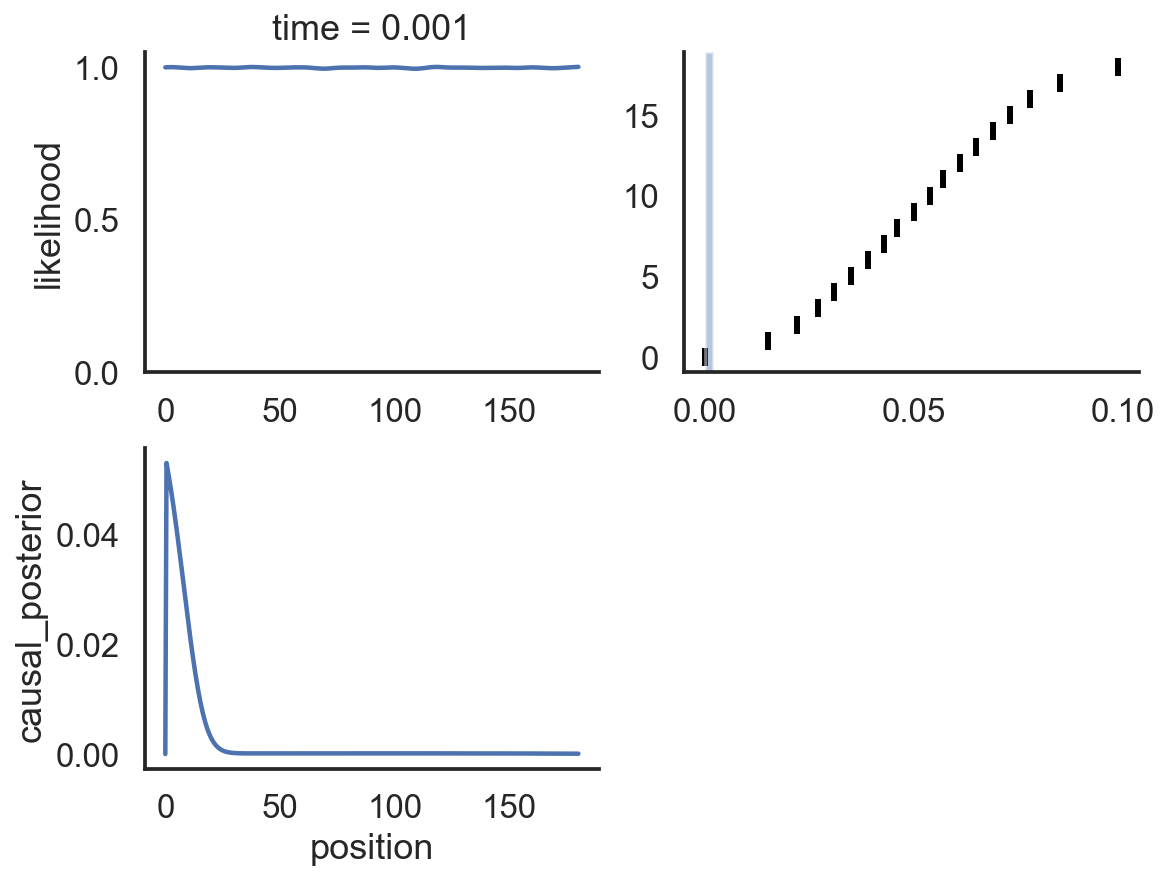

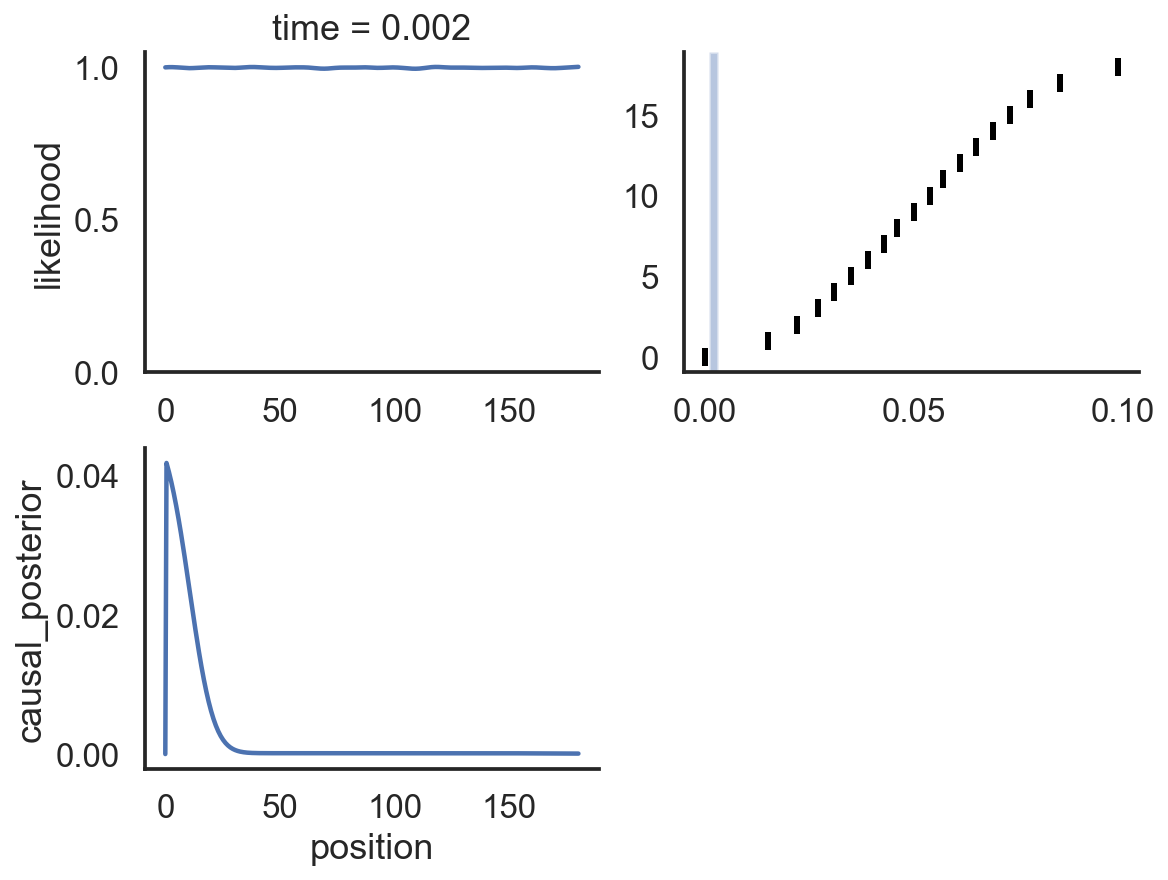

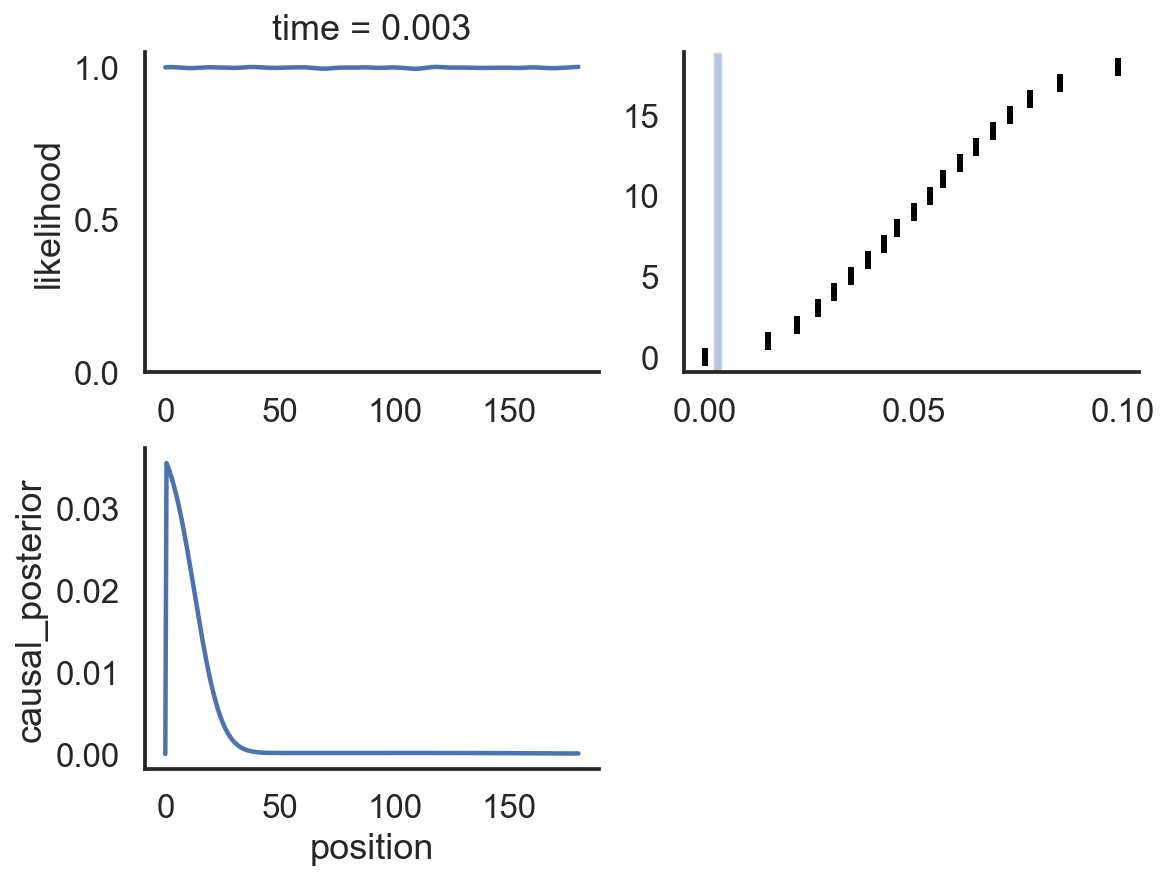

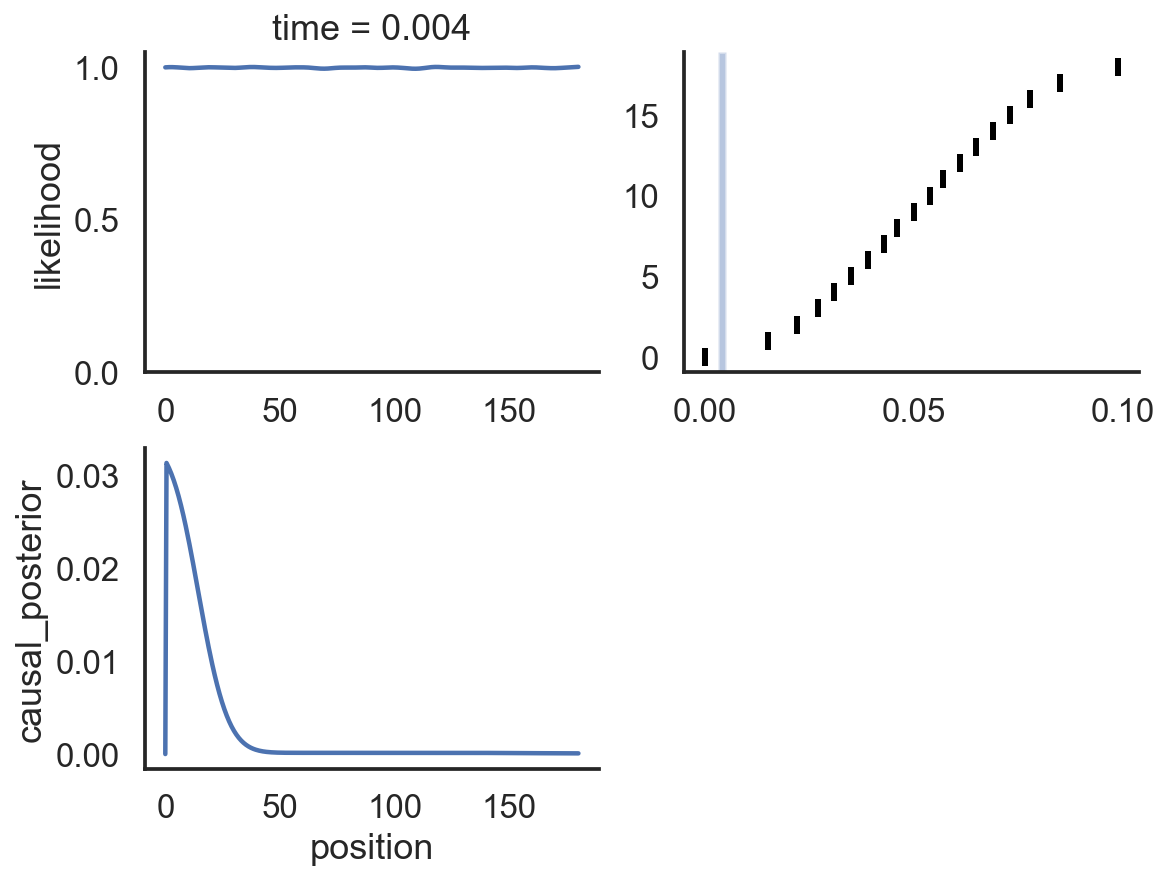

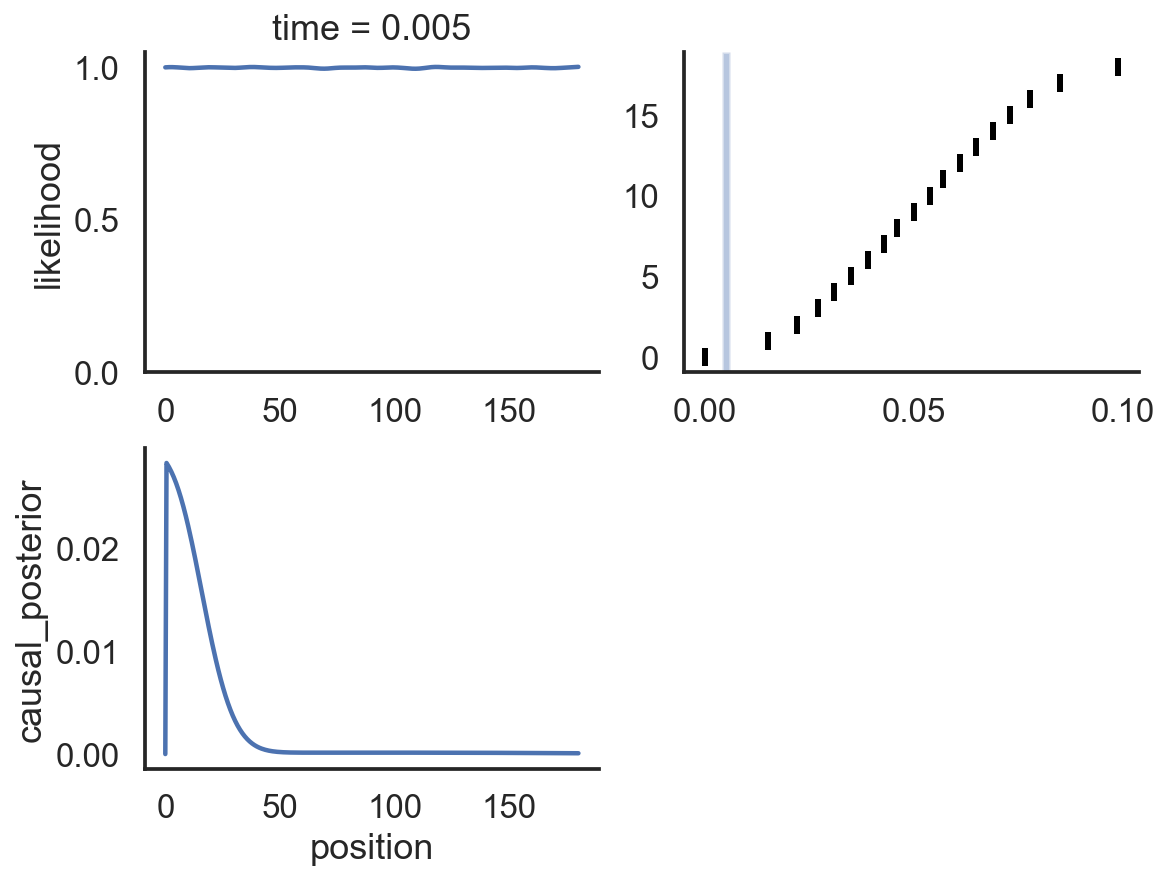

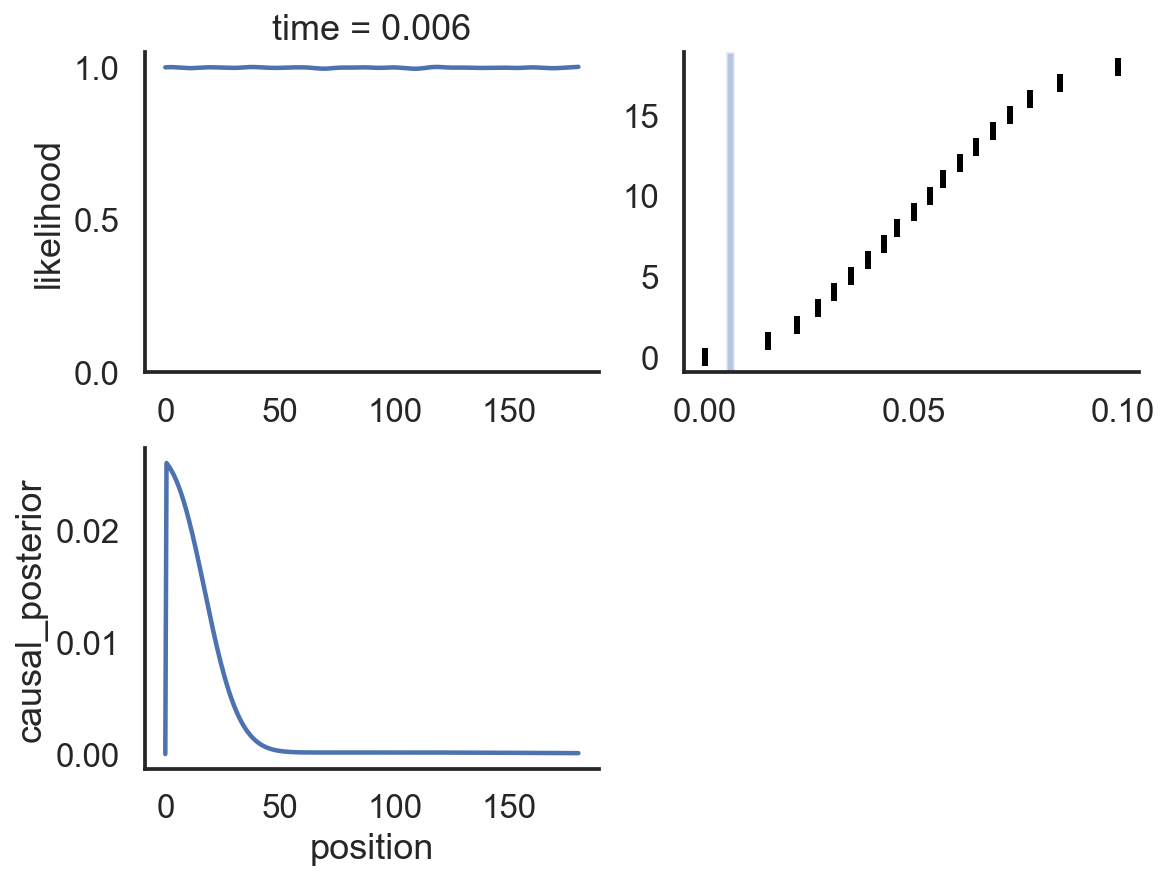

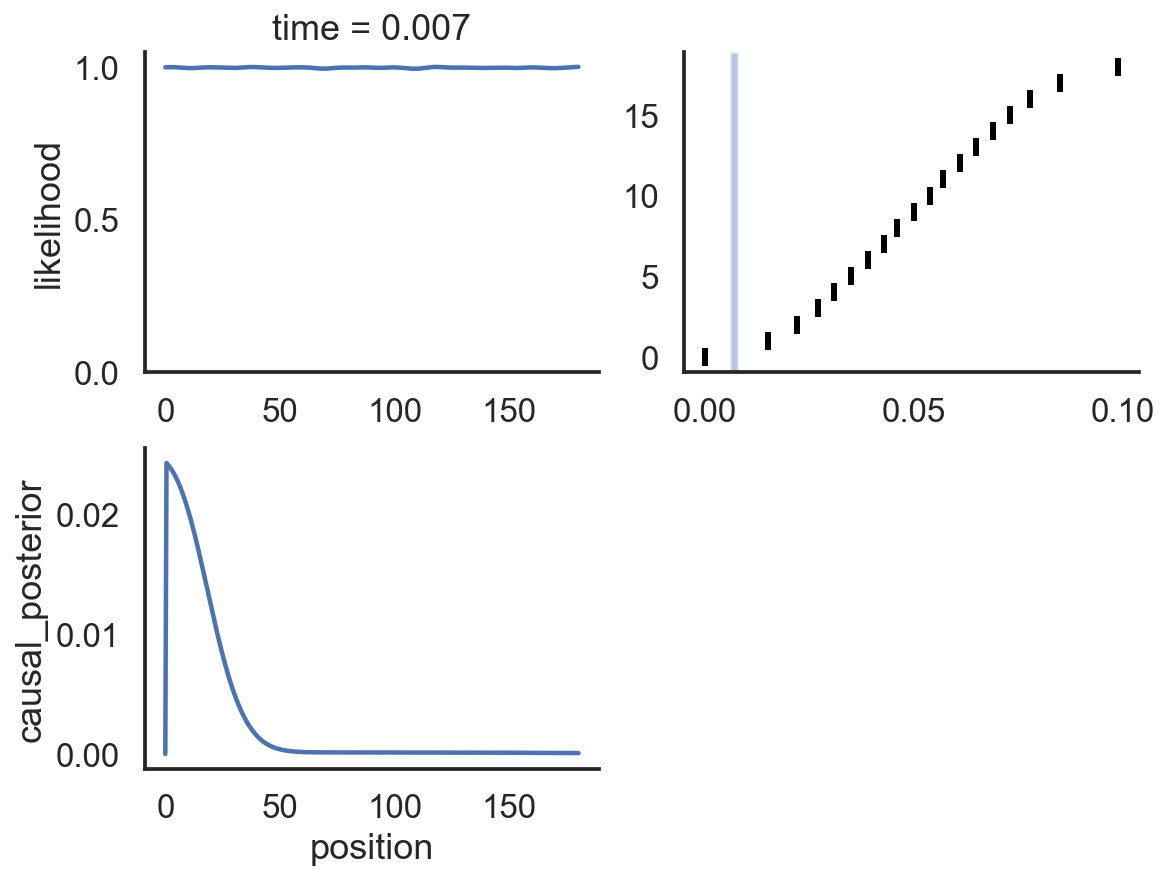

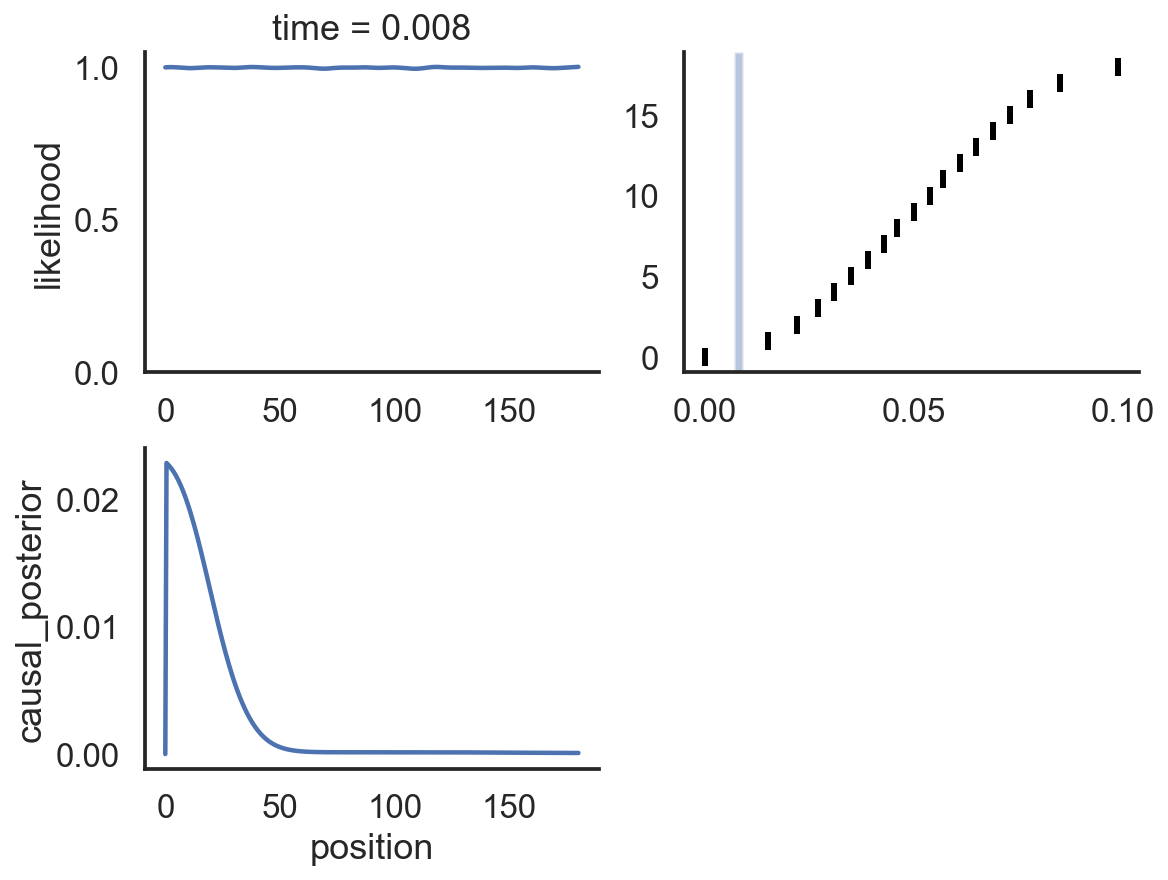

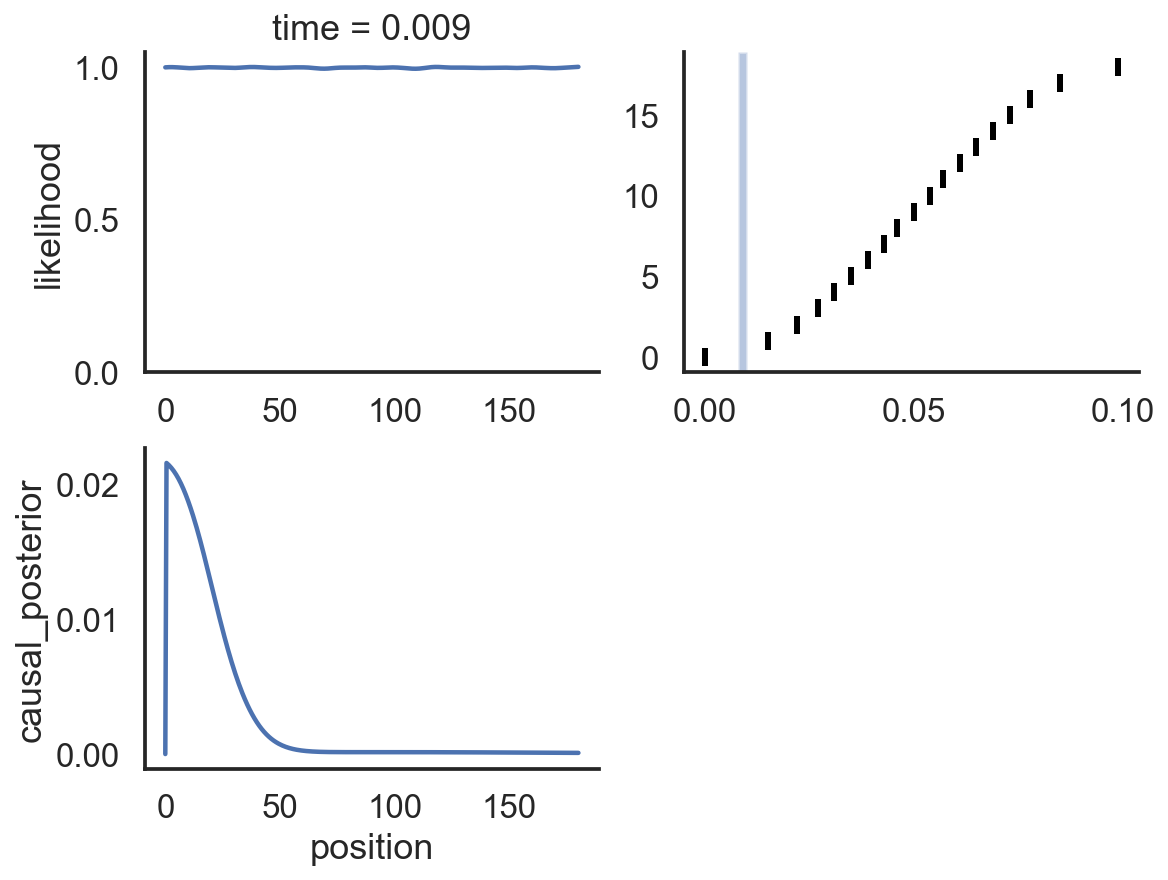

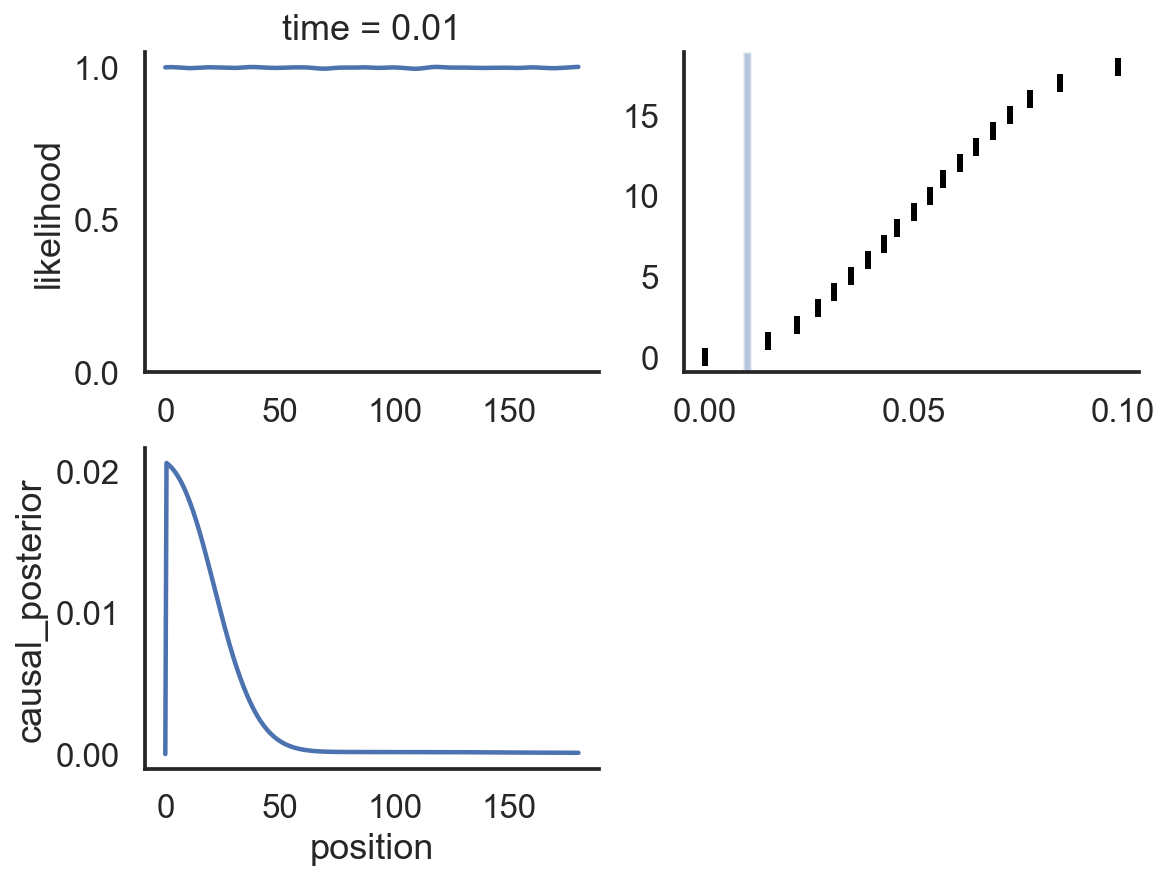

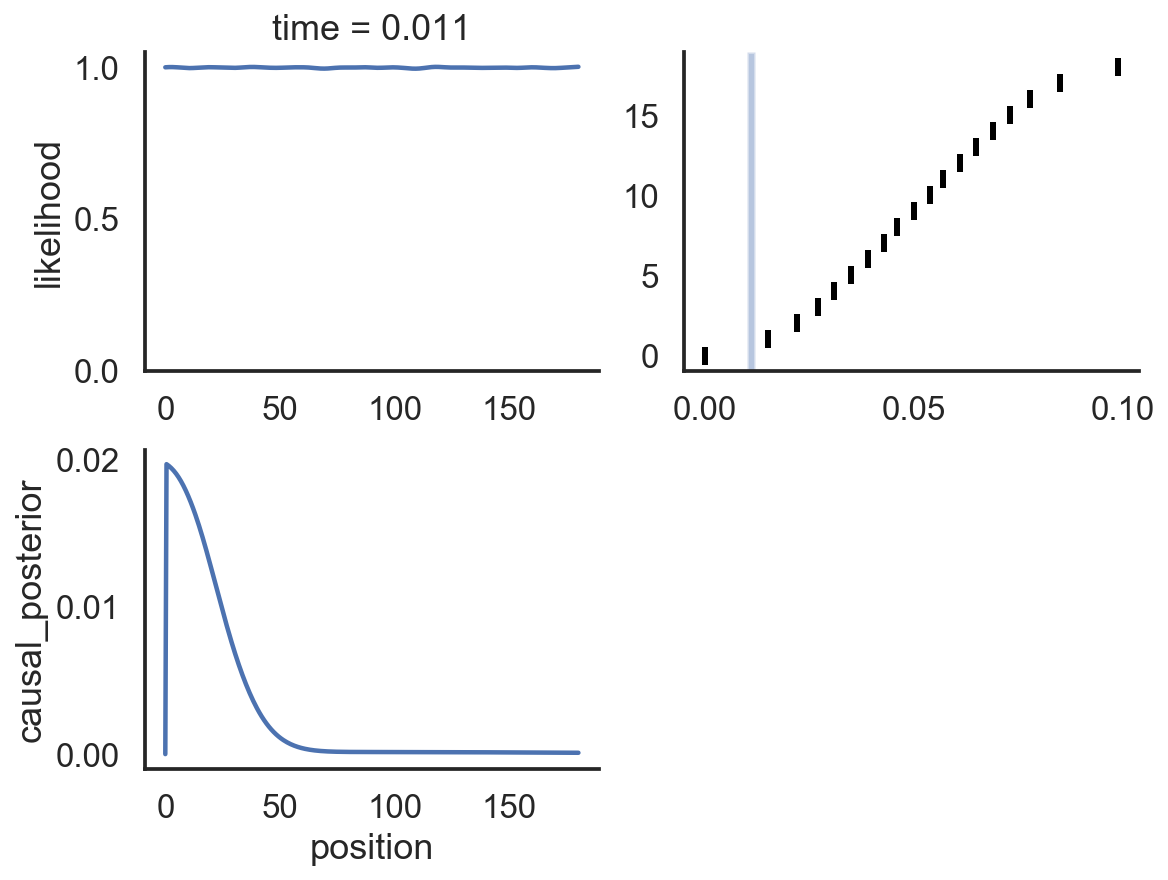

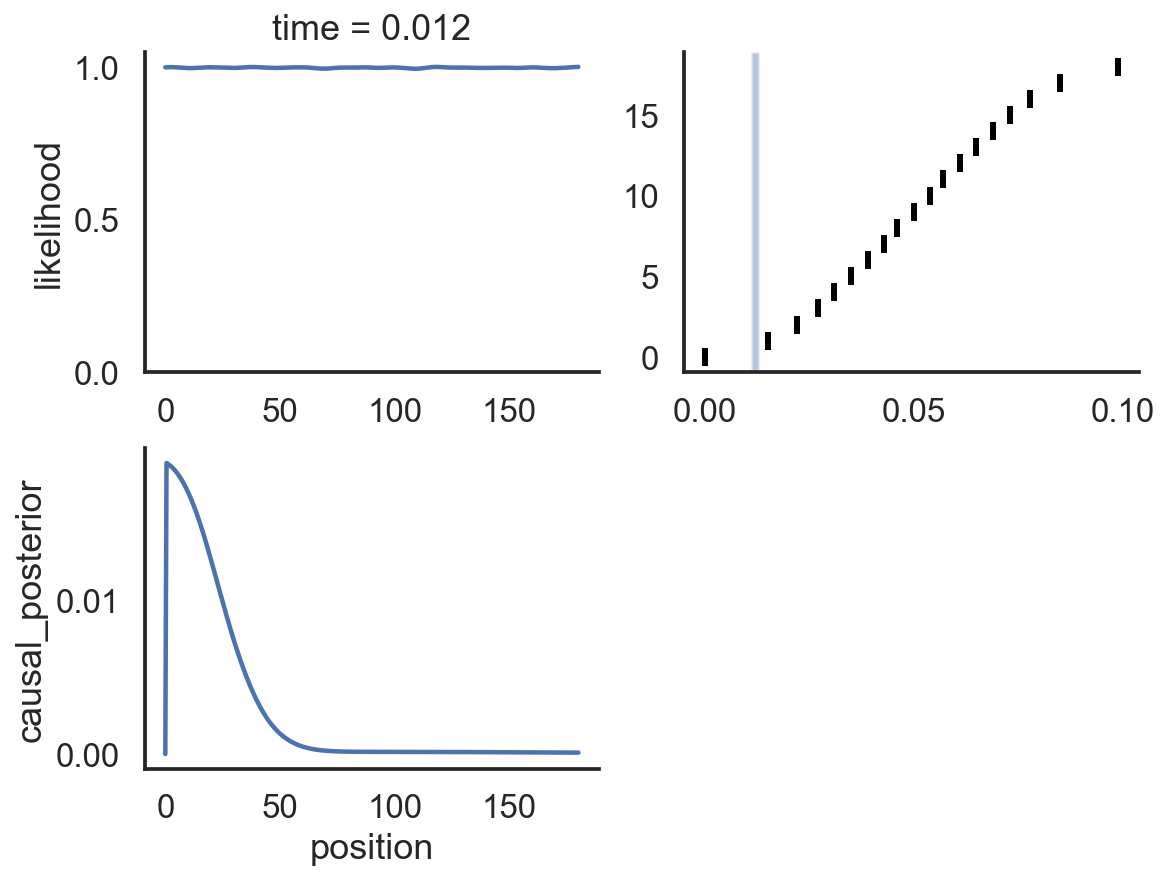

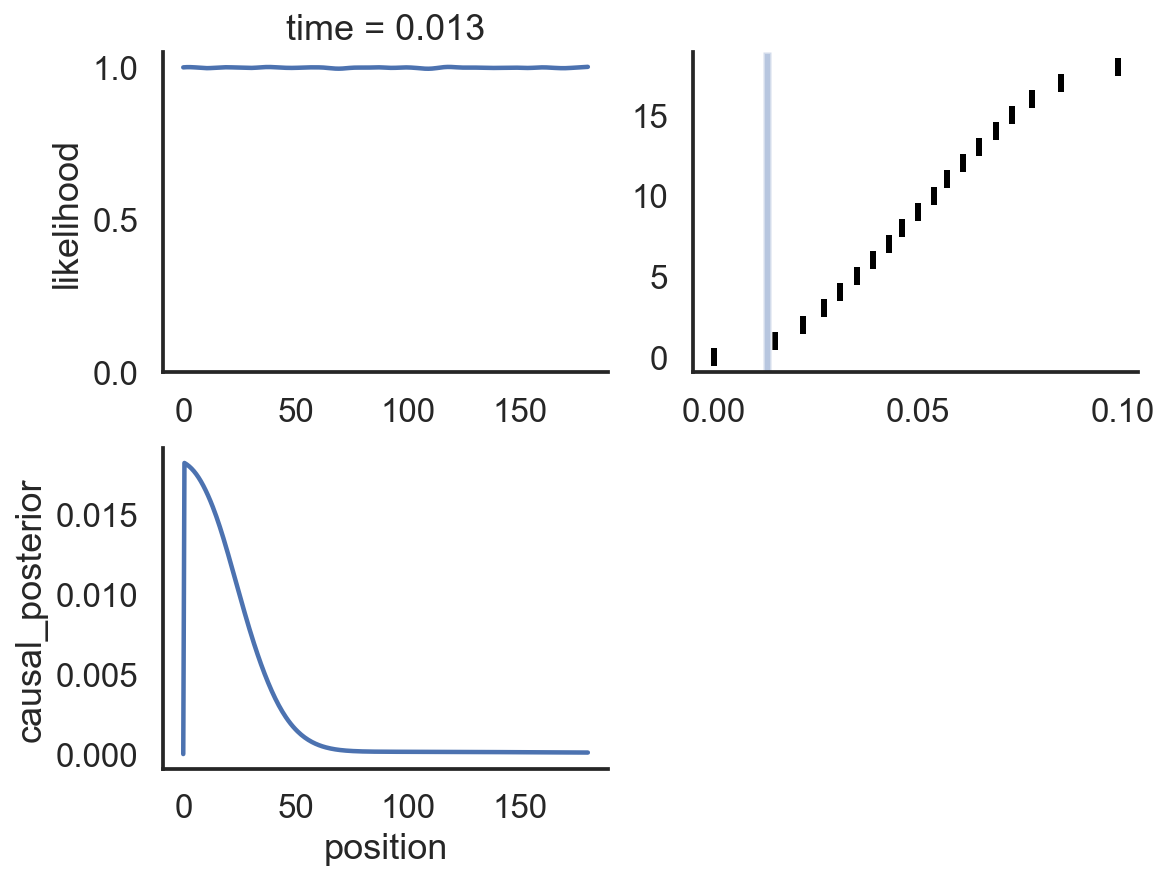

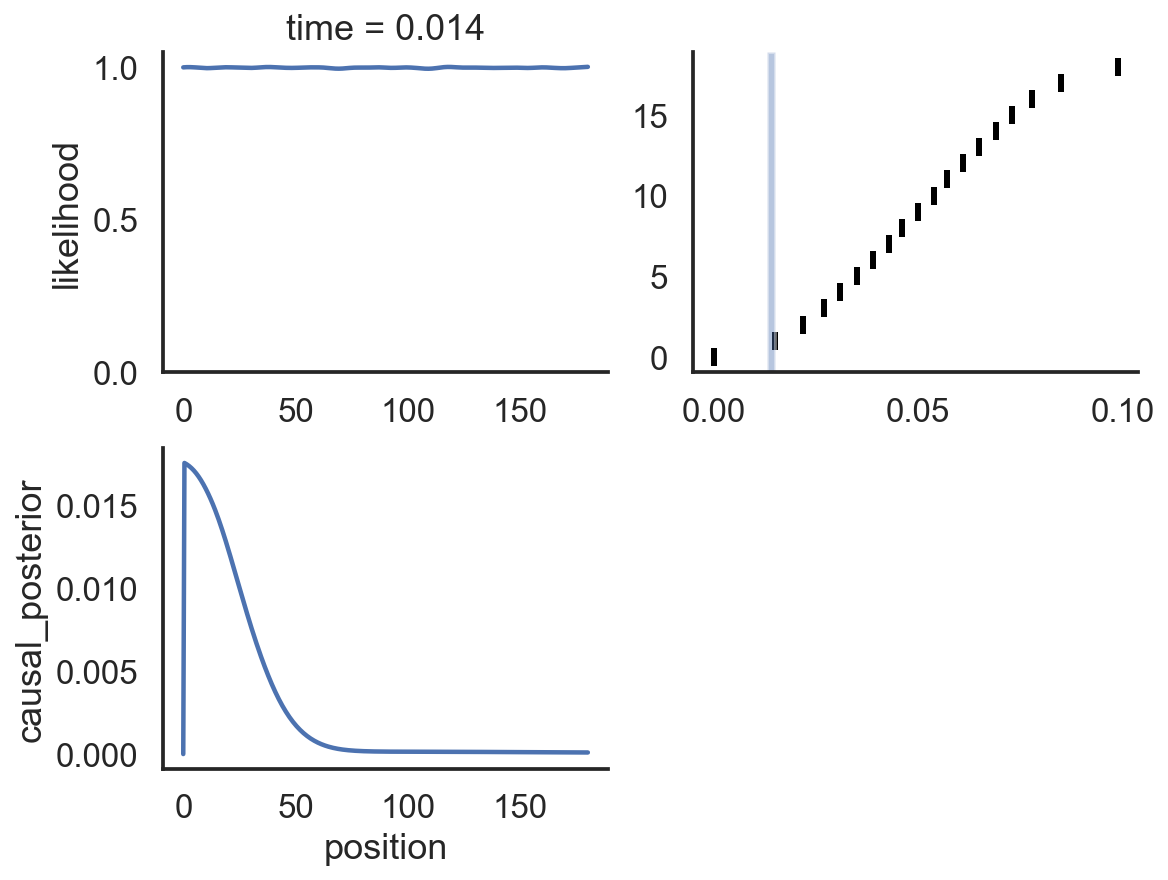

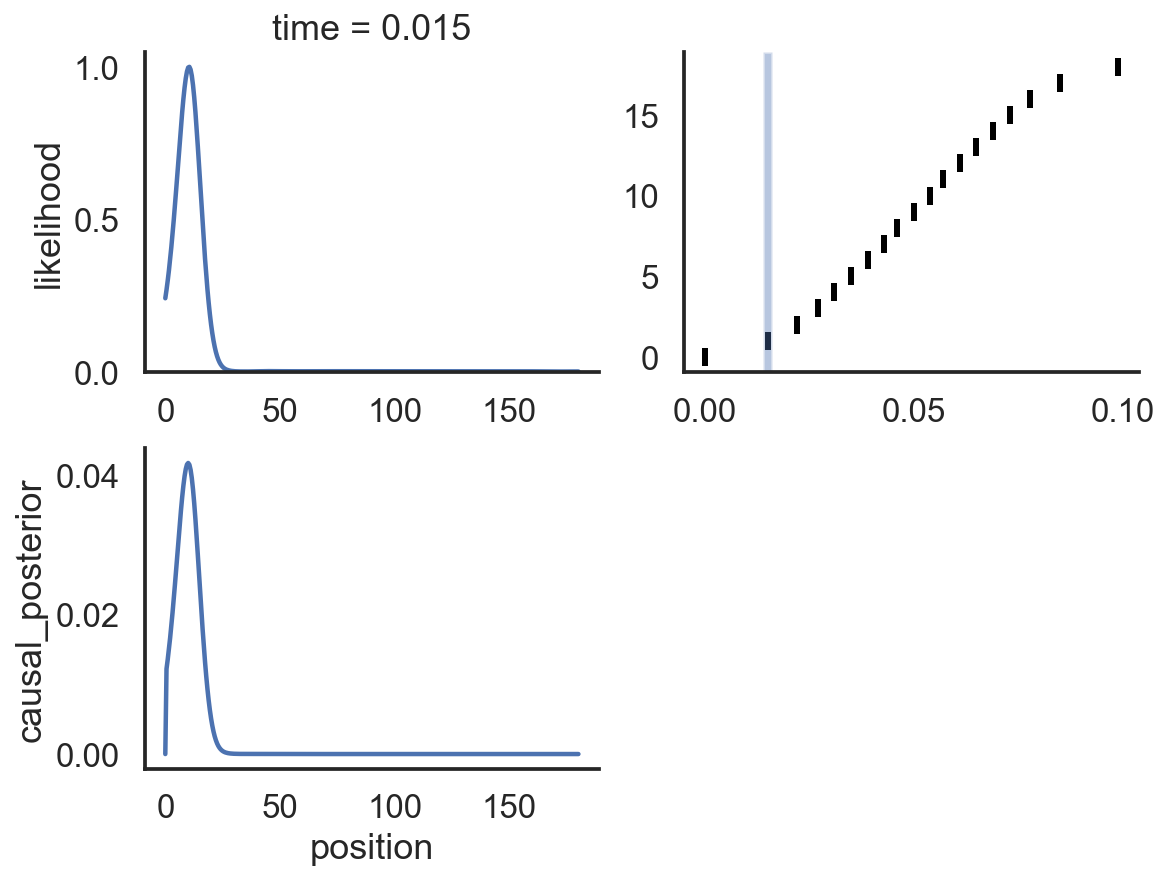

In [55]:
for time_ind in range(16):
    fig, axes = plt.subplots(2, 2, constrained_layout=True, figsize=(8, 6))
    results.isel(time=time_ind).likelihood.plot(ax=axes[0, 0])
    results.isel(time=time_ind).causal_posterior.plot(ax=axes[1, 0])
    axes[0, 0].set_xlabel('')
    axes[0, 0].set_ylim((0, 1.05))
    axes[1, 0].set_title('')

    spike_time_ind, neuron_ind = np.nonzero(test_spikes)
    axes[0, 1].scatter(replay_time[spike_time_ind], neuron_ind, color='black', zorder=1,
                    marker='|', s=80, linewidth=3)
    if time_ind - 1 < 0:
        prev_time = -0.001
    else:
        prev_time = replay_time[time_ind-1]
    axes[0, 1].axvspan(prev_time, replay_time[time_ind+1], alpha=0.4)
    axes[1, 1].axis('off')
    sns.despine()

In [56]:
from src.load_data import load_data

epoch_key = 'bon', 3, 2

data = load_data(epoch_key)

INFO:src.load_data:Finding ripple times...


In [58]:
from src.parameters import (ANIMALS, FIGURE_DIR, PROBABILITY_THRESHOLD,
                            PROCESSED_DATA_DIR, SAMPLING_FREQUENCY,
                            TRANSITION_TO_CATEGORY,
                            continuous_transition_types, discrete_diag,
                            knot_spacing, model, model_kwargs, movement_var,
                            place_bin_size, replay_speed, spike_model_penalty)

is_training = data['position_info'].speed > 4
position = data['position_info'].loc[:, 'linear_position2']
track_labels = data['position_info'].arm_name

real_data_decoder = SortedSpikesDecoder(
    place_bin_size=place_bin_size, movement_var=movement_var,
    replay_speed=replay_speed,
    spike_model_penalty=spike_model_penalty, knot_spacing=knot_spacing).fit(
                position, data['spikes'], is_training=is_training,
                track_labels=track_labels)

INFO:replay_trajectory_classification.decoder:Fitting initial conditions...
INFO:replay_trajectory_classification.decoder:Fitting state transition...
INFO:replay_trajectory_classification.decoder:Fitting place fields...


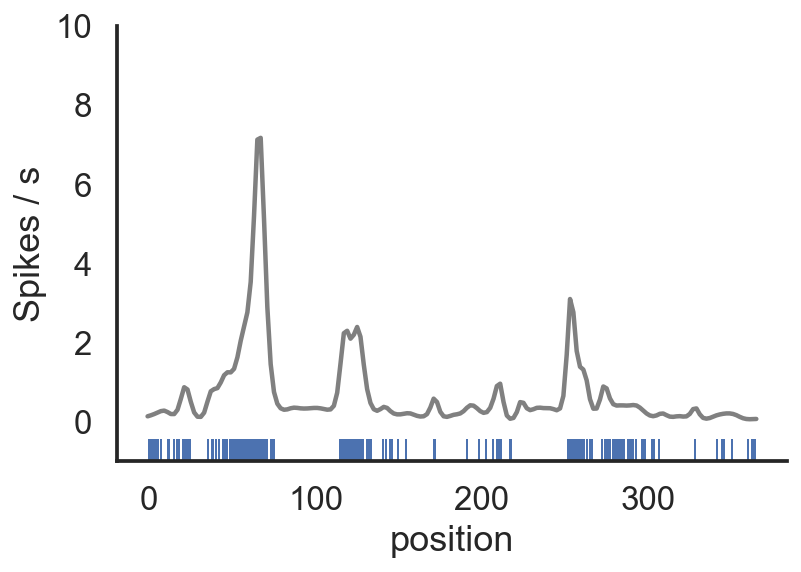

In [228]:
spike_position = data['position_info'].linear_position2.loc[data['spikes'].iloc[:, 0] > 0].values

sns.distplot

fig, ax = plt.subplots()
(real_data_decoder.place_fields_.isel(neuron=0) * 500).plot(ax=ax, color='grey')
plt.ylim((-1, 10))
sns.distplot(spike_position, rug=True, ax=ax, hist=False, kde=False)
ax.set_ylabel('Spikes / s')

sns.despine()

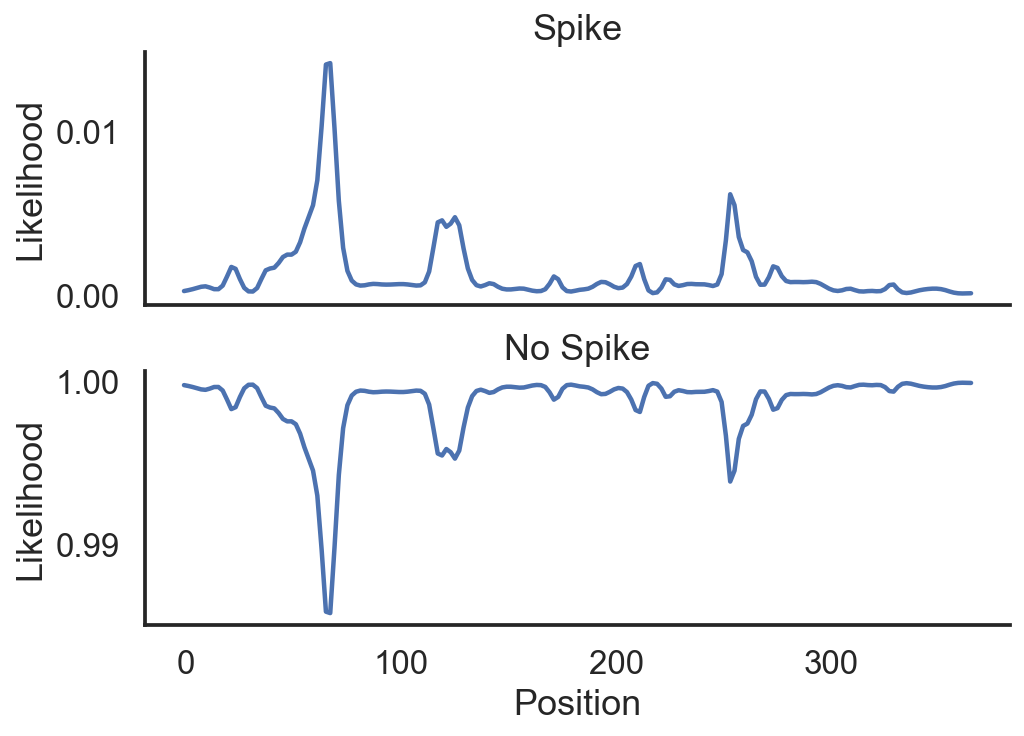

In [108]:
from replay_trajectory_classification.spiking_likelihood import poisson_log_likelihood

likelihood = np.exp(poisson_log_likelihood(np.array([0, 1]), real_data_decoder.place_fields_.isel(neuron=0).values))

fig, axes = plt.subplots(2, 1, constrained_layout=True, figsize=(7, 5), sharex=True)
axes[1].plot(real_data_decoder.place_bin_centers_, likelihood[0])
axes[1].set_title('No Spike')
axes[1].set_ylabel('Likelihood')

axes[0].plot(real_data_decoder.place_bin_centers_, likelihood[1])
axes[0].set_title('Spike')
axes[0].set_ylabel('Likelihood')
axes[-1].set_xlabel('Position')
sns.despine()

In [ ]:
real_data_decoder.place_fields_

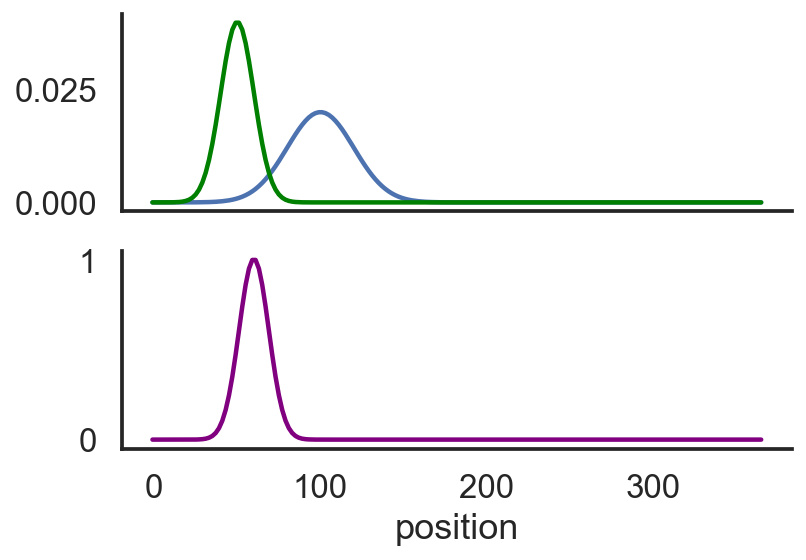

In [265]:
from scipy.stats import norm

predicted = norm.pdf(real_data_decoder.place_bin_centers_, 100, 20)
data_likelihood = norm.pdf(real_data_decoder.place_bin_centers_, 50, 10)
combo = predicted * data_likelihood
combo /= combo.max()

fig, axes = plt.subplots(2, 1, sharex=True)
axes[0].plot(real_data_decoder.place_bin_centers_, predicted)
axes[0].plot(real_data_decoder.place_bin_centers_, data_likelihood, color='green')
axes[1].plot(real_data_decoder.place_bin_centers_, combo, color='purple')
axes[1].set_xlabel('position')
sns.despine()

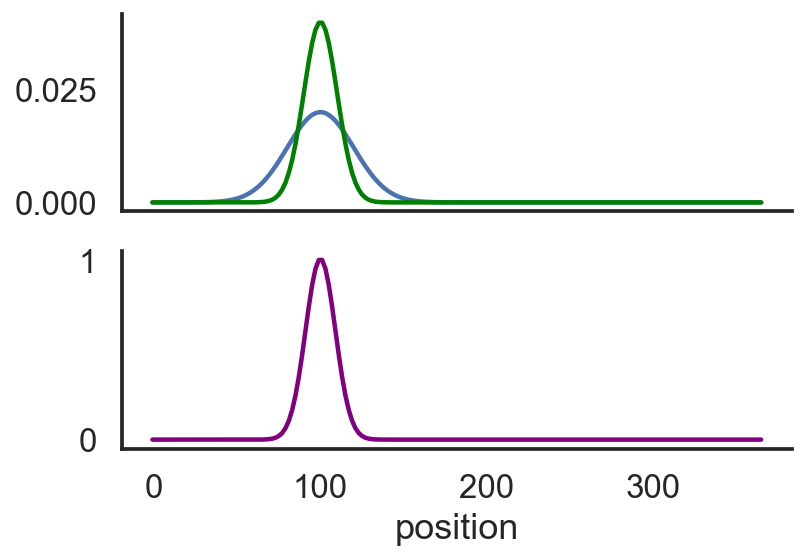

In [268]:
from scipy.stats import norm

predicted = norm.pdf(real_data_decoder.place_bin_centers_, 100, 20)
data_likelihood = norm.pdf(real_data_decoder.place_bin_centers_, 100, 10)
combo = predicted * data_likelihood
combo /= combo.max()

fig, axes = plt.subplots(2, 1, sharex=True)
axes[0].plot(real_data_decoder.place_bin_centers_, predicted)
axes[0].plot(real_data_decoder.place_bin_centers_, data_likelihood, color='green')
axes[1].plot(real_data_decoder.place_bin_centers_, combo, color='purple')
axes[1].set_xlabel('position')
sns.despine()

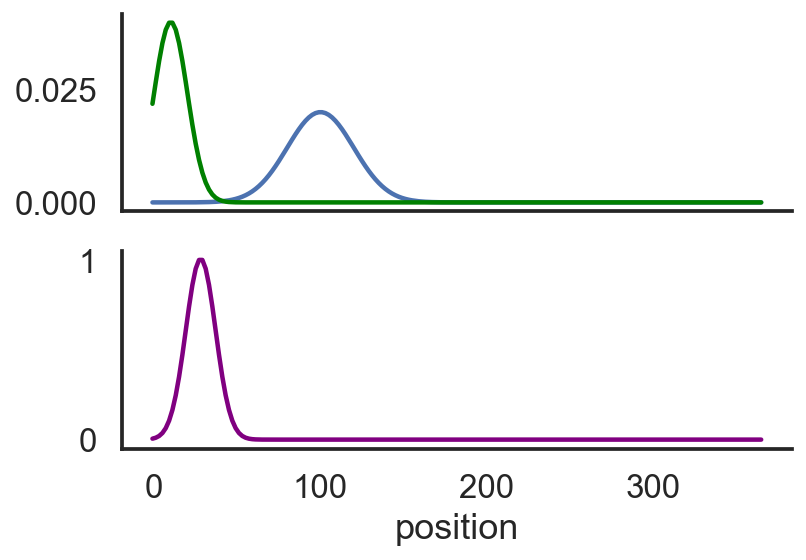

In [267]:
from scipy.stats import norm

predicted = norm.pdf(real_data_decoder.place_bin_centers_, 100, 20)
data_likelihood = norm.pdf(real_data_decoder.place_bin_centers_, 10, 10)
combo = predicted * data_likelihood
combo /= combo.max()

fig, axes = plt.subplots(2, 1, sharex=True)
axes[0].plot(real_data_decoder.place_bin_centers_, predicted)
axes[0].plot(real_data_decoder.place_bin_centers_, data_likelihood, color='green')
axes[1].plot(real_data_decoder.place_bin_centers_, combo, color='purple')
axes[1].set_xlabel('position')
sns.despine()

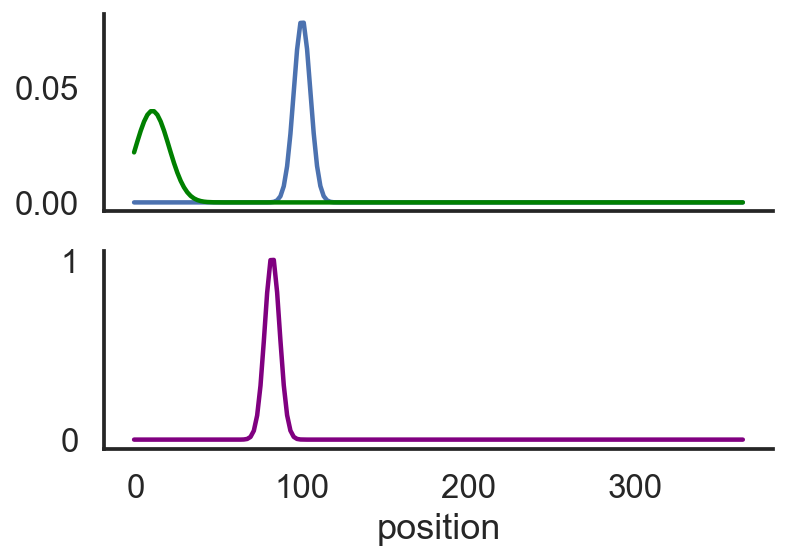

In [266]:
from scipy.stats import norm

predicted = norm.pdf(real_data_decoder.place_bin_centers_, 100, 5)
data_likelihood = norm.pdf(real_data_decoder.place_bin_centers_, 10, 10)
combo = predicted * data_likelihood
combo /= combo.max()

fig, axes = plt.subplots(2, 1, sharex=True)
axes[0].plot(real_data_decoder.place_bin_centers_, predicted)
axes[0].plot(real_data_decoder.place_bin_centers_, data_likelihood, color='green')
axes[1].plot(real_data_decoder.place_bin_centers_, combo, color='purple')
axes[1].set_xlabel('position')
sns.despine()

In [171]:
from replay_trajectory_classification.spiking_likelihood import make_spline_design_matrix, penalized_IRLS
from statsmodels.api import families

def fit_glm(response, design_matrix, penalty=None, tolerance=1E-5):
    if penalty is not None:
        penalty = np.ones((design_matrix.shape[1],)) * penalty
        penalty[0] = 0.0  # don't penalize the intercept
    else:
        penalty = np.finfo(np.float).eps
    return penalized_IRLS(
        design_matrix, response.squeeze(), family=families.Poisson(),
        penalty=penalty, tolerance=tolerance)

design_matrix = make_spline_design_matrix(position.values[:, np.newaxis], knot_spacing)
is_spike = data['spikes'].iloc[:, 0].values

r = fit_glm(is_spike, design_matrix, spike_model_penalty)

In [182]:
from replay_trajectory_classification.simulate import simulate_poisson_spikes

predicted_rate = np.exp(design_matrix @ r.coefficients) * 500

sim_spikes = simulate_poisson_spikes(predicted_rate, 500)

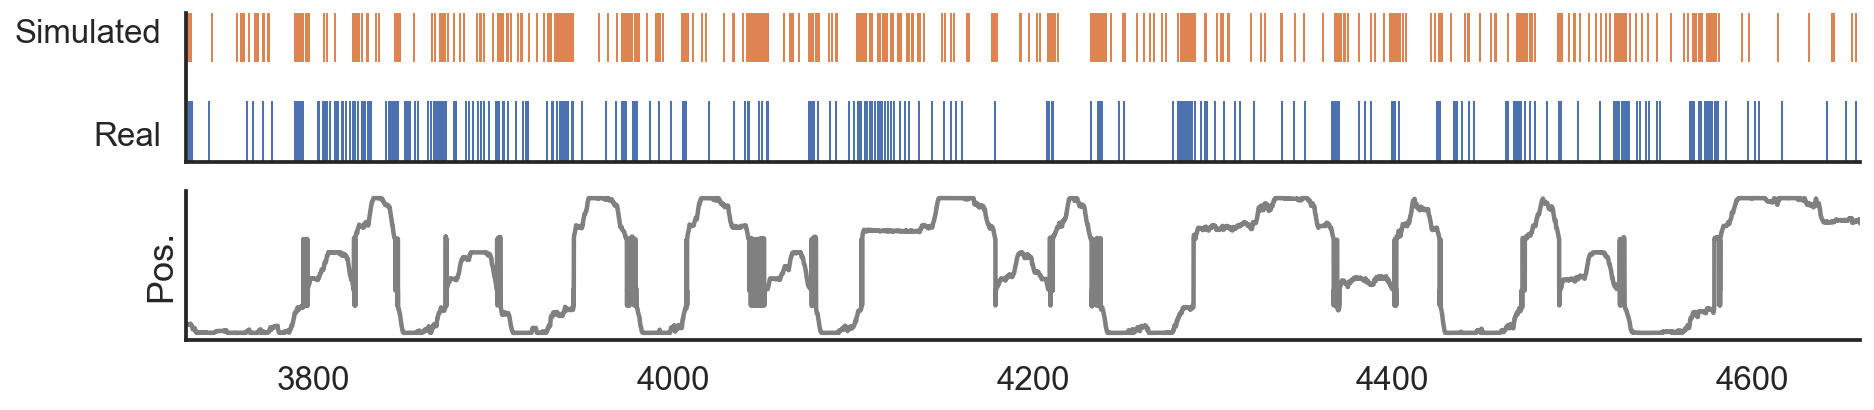

In [226]:
sim_spike_time_ind = np.nonzero(sim_spikes)[0]
spike_time_ind = np.nonzero(is_spike)

time = data['spikes'].index / np.timedelta64(1, 's')

fig, axes = plt.subplots(2, 1, sharex=True, figsize=(15, 3))
axes[0].scatter(time[spike_time_ind], np.ones_like(time[spike_time_ind]), s=1000, marker='|', linewidth=1)
axes[0].scatter(time[sim_spike_time_ind], 2 * np.ones_like(time[sim_spike_time_ind]), s=1000, marker='|', linewidth=1)
axes[0].set_xlim((time.min(), time.max()))
axes[0].set_yticks([1, 2])
axes[0].set_yticklabels(['Real', 'Simulated'])

axes[1].plot(time, position, color='grey')
axes[1].set_ylabel('Pos.')
axes[1].set_yticks([])
sns.despine()

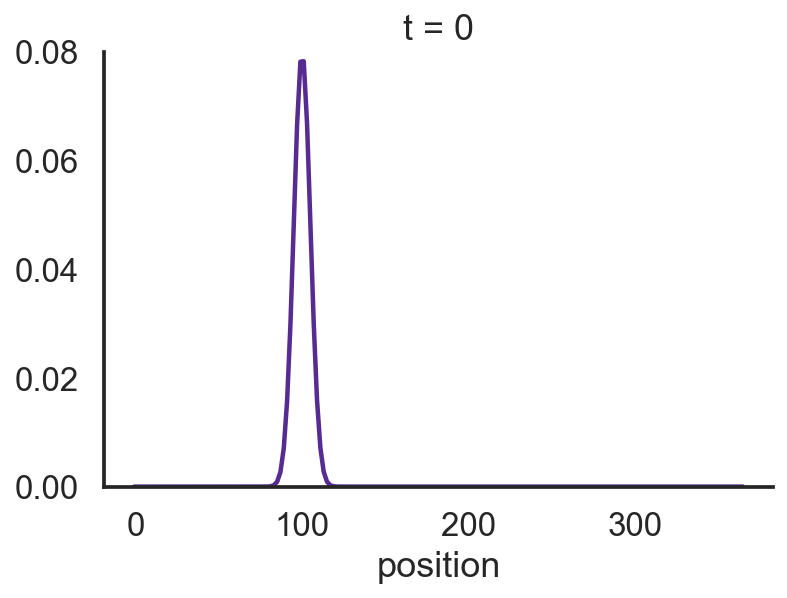

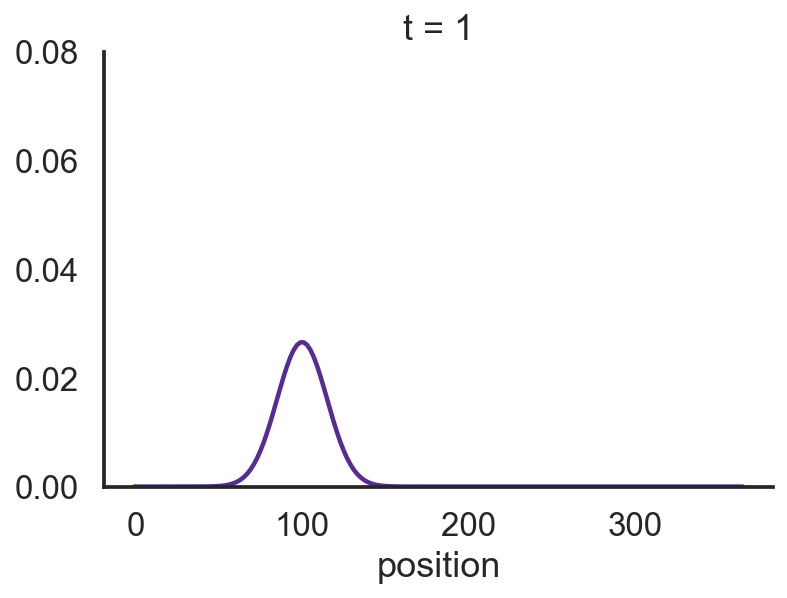

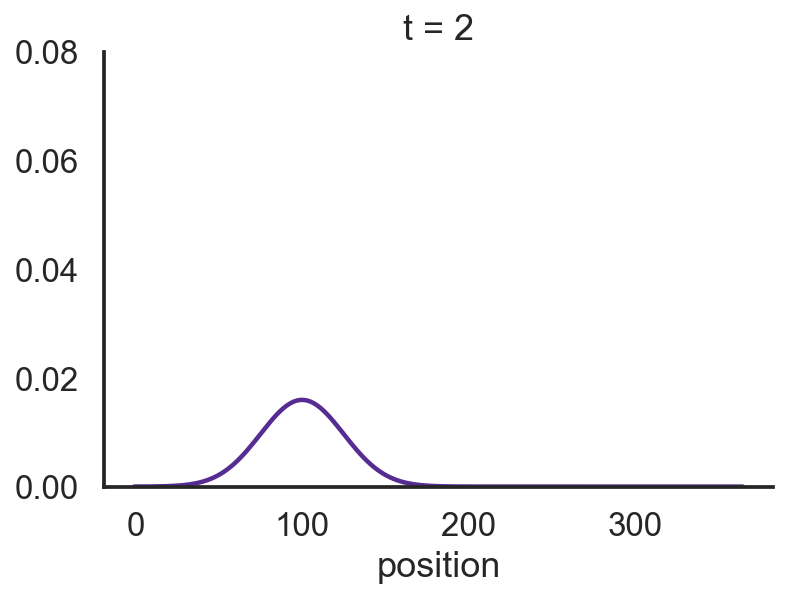

In [264]:
from scipy.stats import norm

predicted = norm.pdf(real_data_decoder.place_bin_centers_, 100, 5)
data_likelihood = norm.pdf(real_data_decoder.place_bin_centers_, 100, 15)
data_likelihood2 = norm.pdf(real_data_decoder.place_bin_centers_, 100, 25)

c = sns.color_palette("Purples")

fig, axes = plt.subplots(1, 1, sharex=True)
axes.plot(real_data_decoder.place_bin_centers_, predicted, color=c[-1])
axes.set_xlabel('position')
axes.set_title('t = 0')
axes.set_ylim((0, 0.08))
sns.despine()


fig, axes = plt.subplots(1, 1, sharex=True)
axes.plot(real_data_decoder.place_bin_centers_, data_likelihood, color=c[-1])
axes.set_xlabel('position')
axes.set_title('t = 1')
axes.set_ylim((0, 0.08))
sns.despine()


fig, axes = plt.subplots(1, 1, sharex=True)
axes.plot(real_data_decoder.place_bin_centers_, data_likelihood2, color=c[-1])
axes.set_xlabel('position')
axes.set_title('t = 2')
axes.set_ylim((0, 0.08))
sns.despine()